# Fun with Maps

*This is work in progress*

Display random locations on a map and try to find funny shapes in them.

## Dependencies

In [ ]:
using System.Net.Http;
using System.Globalization;
using System.IO;

using static Microsoft.DotNet.Interactive.Formatting.PocketViewTags;

var random = new Random();
var httpClient = new HttpClient();

## Step 1: Get images from map locations

The project will be using using [Azure Maps](https://azure.microsoft.com/en-us/services/maps/) to retrieve the map images. Images will be stored in the `images` folder.

### Configuration

Create an [Azure Maps account](https://docs.microsoft.com/en-us/azure/azure-maps/quick-demo-map-app#create-an-azure-maps-account) and get the primary key for that account.

In [ ]:
var azureMapsSubscriptionKey = "<your-subscription-key>";

### Pick random locations

Select a random zoom level and a random location ([As per documentation](https://docs.microsoft.com/en-us/rest/api/maps/render/get-map-image))

* _Zoom level_ ranges from 0 to 20.
* _Longitude_ range: -180 to 180.
* _Latitude_ range: -85 to 85.

In [ ]:
// actual ranges are slightly different from documentation, to get more interesting results
var zoomLevelRange = 5..13;
var longitudeRange = 0..180;
var latitudeRange = 0..75;

In [ ]:
var numberOfImages = 8;

var imageLocations = Enumerable.Range(0, numberOfImages)
	.Select(i => new
	{
		ZoomLevel = random.Next(zoomLevelRange.Start.Value, zoomLevelRange.End.Value),
		Longitude = random.NextDouble() * (2 * longitudeRange.End.Value) - longitudeRange.End.Value,
		Latitude = random.NextDouble() * (2 * latitudeRange.End.Value) - latitudeRange.End.Value,
	})
	.ToArray();
display(imageLocations);

index,ZoomLevel,Longitude,Latitude
0,9,150.07356940117523,16.76723161861797
1,9,-6.155932693742557,-36.3206425039751
2,7,119.8011456639673,-2.0520365842813817
3,5,-134.56899591686658,62.561240324084025
4,6,-41.649011850416315,-71.87942868549361
5,10,104.25148700917953,4.575498559456321
6,10,-32.24868990719892,-44.24368690855826
7,11,-64.15831639072223,42.07639405725379


### Build the map API calls

In [ ]:
var cultureInfo = CultureInfo.InvariantCulture;

var baseUri = "https://atlas.microsoft.com/map/static/png";
var queryParameters = new Dictionary<string, string>
{
	{ "subscription-key", azureMapsSubscriptionKey },
	{ "api-version", "1.0" },
	{ "width", "256" },
	{ "height", "256" },
};

var imageUriList = imageLocations
	.Select(location => {
		queryParameters["center"] = $"{location.Longitude.ToString(cultureInfo)},{location.Latitude.ToString(cultureInfo)}";
		queryParameters["zoom"] = $"{location.ZoomLevel}";

		return new Uri(baseUri + "?" + string.Join("&", queryParameters.Select(kvp => $"{kvp.Key}={kvp.Value}")));
	})
	.ToArray();

display(imageUriList.Select(uri => uri.ToString().Replace(azureMapsSubscriptionKey, "<OBFUSCATED>")));


index,value
0,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=150.07356940117523,16.76723161861797&zoom=9"
1,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-6.155932693742557,-36.3206425039751&zoom=9"
2,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=119.8011456639673,-2.0520365842813817&zoom=7"
3,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-134.56899591686658,62.561240324084025&zoom=5"
4,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-41.649011850416315,-71.87942868549361&zoom=6"
5,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=104.25148700917953,4.575498559456321&zoom=10"
6,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-32.24868990719892,-44.24368690855826&zoom=10"
7,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-64.15831639072223,42.07639405725379&zoom=11"


### Fetch images

In [ ]:
var imageFetchingTasks = imageUriList.Select(uri => 
	httpClient.GetAsync(uri).ContinueWith(task => task.Result.Content.ReadAsByteArrayAsync()));
var images = await Task.WhenAll(imageFetchingTasks);


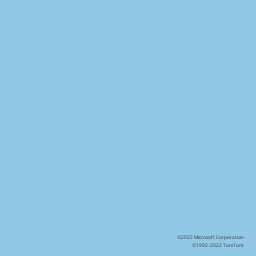
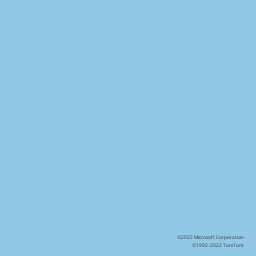
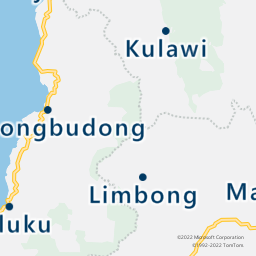
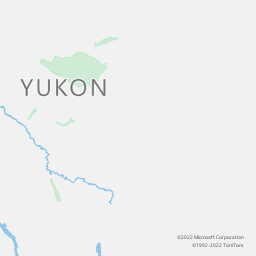
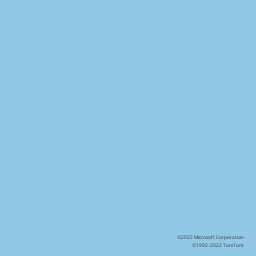
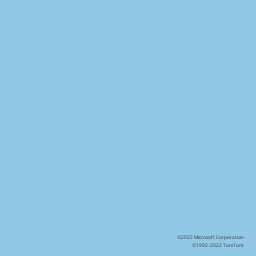
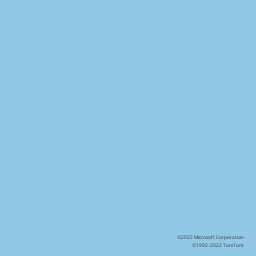
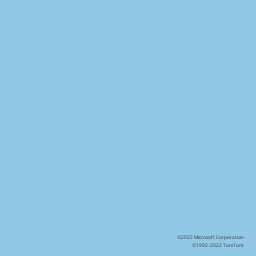

In [ ]:
display(
	HTML(
		string.Join("", images.Select(image => 
			span(
				img[src: "data:image/png;base64," + Convert.ToBase64String(image.Result), style: "padding: 15px"]
			)))
	)
);

## Store images on disk

In [ ]:
var imageFolder = "output/step1";

imageLocations
	.Zip(images, (location, image) => new { 
		FileName = $"{imageFolder}/{location.ZoomLevel}__{location.Longitude.ToString(cultureInfo)}__{location.Latitude.ToString(cultureInfo)}.png",
		Image = image.Result
	})
	.ToList()
	.ForEach(image => File.WriteAllBytes(image.FileName, image.Image));